In [1]:
# Functions we used to generate data
# Implement and test the Random Forest model

In [1]:
import pandas as pd
import numpy as np
import  wxee
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
try:
    import geemap, ee
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
    import geemap, ee

In [3]:
try:
        geemap.ee_initialize()
except Exception as e:
        geemap.ee_initialize()
        geemap.ee_initialize()

from geemap import geojson_to_ee, ee_to_geojson
import eemont

We have obtained two datasets from the City of Chicago Portal.
These datasets contain service requests from citizens
Among those requests there are some regarding abandoned buildigs and  vacant areas.


In [ ]:
# We have obtained two datasets from the City of Chicago Portal.
# These datasets contain service requests from citizens
# Among those requests there are some regarding abandoned buildigs and  vacant areas.
# 

# Load chicago service calls and then take the abandoned buildings reports from that
chicago_service_new = pd.read_csv("./data/csvs/311_Service_Requests_new.csv")
chicago_service_new

Select some features rellevant to abandoned and not abandoned buildigs. We follow the assumption that buillding violation indicates non vacaant property.

In [ ]:
chicago_pois_new = chicago_service_new.loc[chicago_service_new['SR_TYPE'].isin(['Vacant/Abandoned Building Complaint','Clean Vacant Lot Request',
                                                             'Shared Housing/Vacation Rental Complaint','Building Violation',
                                                              'Water Quality Concern'])].reset_index().drop('index',axis=1)
chicago_pois_new

In [ ]:
# chicago_abandoned_new = chicago_pois_new.loc[chicago_pois_new['SR_TYPE'].isin(['Vacant/Abandoned Building Complaint',
#                                                                    'Clean Vacant Lot Request'])].reset_index().drop('index',axis=1)

# Drop the columns that are not interesting to us according to our assumptions

# Let's assume that shared housing,water quality and building violation correlated to not abandoned buildings
chicago_abandoned_new = chicago_pois_new.loc[chicago_pois_new['SR_TYPE'].isin(['Vacant/Abandoned Building Complaint',
                                                                   'Clean Vacant Lot Request'])]
chicago_abandoned_new = chicago_abandoned_new[['LATITUDE','LONGITUDE','LOCATION']].dropna()
#chicago_abandoned_new = chicago_abandoned_new.reset_index()
#chicago_abandoned = chicago_abandoned.drop(chicago_abandoned.index)
#chicago_abandoned_new = chicago_abandoned_new.set_index(chicago_abandoned_new.index)
# Let's assume that shared housing,water quality and building violation correlated  to not abandoned buildings
chicago_not_abandoned_new = chicago_pois_new.loc[chicago_pois_new['SR_TYPE'].isin(['Shared Housing/Vacation Rental Complaint','Building Violation',
                                                       'Water Quality Concern'])]
#chicago_not_abandoned_new
chicago_not_abandoned_new = chicago_not_abandoned_new[['LATITUDE','LONGITUDE','LOCATION']].dropna()

chicago_abandoned=chicago_abandoned_new.reset_index().drop('index',axis=1)
chicago_not_abandoned=chicago_not_abandoned_new.reset_index().drop('index',axis=1)

#use geemap to turn this dataframe into a gee feature collection
chicago_abandoned_sample = chicago_abandoned.sample(n=1000).reset_index().drop('index',axis=1)
chicago_not_abandoned_sample=chicago_not_abandoned.sample(n=1000).reset_index().drop('index',axis=1)
chicago_abandoned_fc   = geemap.df_to_ee(chicago_abandoned_sample,latitude='LATITUDE',longitude='LONGITUDE')
chicago_not_abandoned_fc  =geemap.df_to_ee(chicago_not_abandoned_sample,latitude='LATITUDE',longitude='LONGITUDE')

In [ ]:
#generate time series over aoi, get spectral indices(awsome index) #  fixed
import time
from datetime import timedelta
def generate_time_series_regions(geometry,startDate,endDate):
    print('start  collecting satellite  images')
    
    start_time = time.monotonic()
    
    #collect imageCollection
    
    s2 = (ee.ImageCollection("COPERNICUS/S2_SR")#.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 5)
      .filterDate(startDate,endDate)
      .filterBounds(geometry)
      .maskClouds()
      .scaleAndOffset()
      .spectralIndices(['NDVI','NDBI','IBI','EMBI','VgNIRBI','VrNIRBI','PISI'],online=True)).select([ 'NDVI', 'NDBI', 'IBI', 
                                                                                              'EMBI','VgNIRBI','VrNIRBI','PISI'])

    print(len(s2))
    ts = s2.wx.to_time_series()
    
    
    #cloudless = ts.filterBounds(geometry).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 5)
    #use geemap to generate a pandas dataframe from the time series(contains the ts for the selected indices)
    #satellite_df= geemap.ee_to_pandas(time_series)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print('done collecting')
    
    print('start  calculating ts')
    start_time = time.monotonic()
    ts_mean =ts.aggregate_time(frequency="month",reducer=ee.Reducer.mean())#.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
    time_series = ts_mean.getTimeSeriesByRegions(
                               collection = geometry,
                               bands = ['NDVI','NDBI','IBI','EMBI','VgNIRBI','VrNIRBI','PISI'],
                               reducer = [ee.Reducer.mean()],
                               scale = 10)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print('done calculating ts')
    print(len(time_series))
    print('start  making dataframe ts')
    start_time = time.monotonic()
    satellite_df = geemap.ee_to_pandas(time_series)

    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    print('done making dataframe ts')
    satellite_df[satellite_df == -9999] = np.nan
    #satellite_df[satellite_df > -9999] = np.nan
    #filter outliers
    #satellite_df1=pd.DataFrame()
    #satellite_df1['date'] =
    #satellite_df=satellite_df[(np.abs(stats.zscore(satellite_df.drop(['date','reducer'],axis=1))) < 3).all(axis=1)]#==np.nan
    satellite_df['date']=pd.to_datetime(satellite_df['date'],infer_datetime_format = True)
    satellite_df['NDVI']=satellite_df['NDVI'].fillna(satellite_df['NDVI'].mean())
    satellite_df['NDBI']=satellite_df['NDBI'].fillna(satellite_df['NDBI'].mean())
    satellite_df['EMBI']=satellite_df['EMBI'].fillna(satellite_df['EMBI'].mean())
    satellite_df['IBI']=satellite_df['IBI'].fillna(satellite_df['IBI'].mean())
    satellite_df['VgNIRBI']=satellite_df['VgNIRBI'].fillna(satellite_df['VgNIRBI'].mean())
    satellite_df['VrNIRBI']=satellite_df['VrNIRBI'].fillna(satellite_df['VrNIRBI'].mean())
    satellite_df['PISI']=satellite_df['PISI'].fillna(satellite_df['PISI'].mean())
    #satellite_df['date'] = satellite_df1['date']
    return satellite_df

In [ ]:
# calculate time series for different years separetly due to computational limits,and then append
#2019
abandoned_chicago_regions19_1 = generate_time_series_regions(chicago_abandoned_fc,'2019-01-01','2019-06-01')
abandoned_chicago_regions19_2 = generate_time_series_regions(chicago_abandoned_fc,'2019-06-01','2019-9-01')
abandoned_chicago_regions19_3 = generate_time_series_regions(chicago_abandoned_fc,'2019-09-01','2020-01-01')
abandoned_chicago_regions19  = abandoned_chicago_regions19_1.append(abandoned_chicago_regions19_2.append(abandoned_chicago_regions19_3),ignore_index=True)

#2020
abandoned_chicago_regions20_1 = generate_time_series_regions(chicago_abandoned_fc,'2020-01-01','2020-06-01')
abandoned_chicago_regions20_2 = generate_time_series_regions(chicago_abandoned_fc,'2020-06-01','2020-09-01')
abandoned_chicago_regions20_3 = generate_time_series_regions(chicago_abandoned_fc,'2020-09-01','2021-01-01')
abandoned_chicago_regions20  = abandoned_chicago_regions20_1.append(abandoned_chicago_regions20_2.append(abandoned_chicago_regions20_3),ignore_index=True)

#2021
abandoned_chicago_regions21_1 = generate_time_series_regions(chicago_abandoned_fc,'2021-01-01','2021-06-01')
abandoned_chicago_regions21_2 = generate_time_series_regions(chicago_abandoned_fc,'2021-06-01','2021-09-01')
abandoned_chicago_regions21_3 = generate_time_series_regions(chicago_abandoned_fc,'2021-09-01','2022-01-01')
abandoned_chicago_regions21  = abandoned_chicago_regions21_1.append(abandoned_chicago_regions21_2.append(abandoned_chicago_regions21_3),ignore_index=True)

#2022
abandoned_chicago_regions22_1 = generate_time_series_regions(chicago_abandoned_fc,'2021-01-01','2021-05-01')


abandoned_chicago_regions=abandoned_chicago_regions19.append(abandoned_chicago_regions20.append(abandoned_chicago_regions21.append(abandoned_chicago_regions22_1)),ignore_index=True)

In [ ]:
# The generated time series dataset for s2 spectral indices
abandoned_chicago_regions =  pd.read_csv('./data/csvs/abandoned_chicago_s2.csv')

In [ ]:
# Follow the same procedure for not abandoned

#2019
not_abandoned_chicago_regions19_1 = generate_time_series_regions(chicago_not_abandoned_fc,'2019-01-01','2019-06-01')
not_abandoned_chicago_regions19_2 = generate_time_series_regions(chicago_not_abandoned_fc,'2019-06-01','2019-9-01')
not_abandoned_chicago_regions19_3 = generate_time_series_regions(chicago_not_abandoned_fc,'2019-09-01','2020-01-01')
not_abandoned_chicago_regions19  = not_abandoned_chicago_regions19_1.append(not_abandoned_chicago_regions19_2.append(not_abandoned_chicago_regions19_3),ignore_index=True)

#2020
not_abandoned_chicago_regions20_1 = generate_time_series_regions(chicago_not_abandoned_fc,'2020-01-01','2020-06-01')
not_abandoned_chicago_regions20_2 = generate_time_series_regions(chicago_not_abandoned_fc,'2020-06-01','2020-09-01')
not_abandoned_chicago_regions20_3 = generate_time_series_regions(chicago_not_abandoned_fc,'2020-09-01','2021-01-01')
not_abandoned_chicago_regions20  = not_abandoned_chicago_regions20_1.append(not_abandoned_chicago_regions20_2.append(not_abandoned_chicago_regions20_3),ignore_index=True)

#2021
not_abandoned_chicago_regions21_1 = generate_time_series_regions(chicago_not_abandoned_fc,'2021-01-01','2021-06-01')
not_abandoned_chicago_regions21_2 = generate_time_series_regions(chicago_not_abandoned_fc,'2021-06-01','2021-09-01')
not_abandoned_chicago_regions21_3 = generate_time_series_regions(chicago_not_abandoned_fc,'2021-09-01','2022-01-01')
not_abandoned_chicago_regions21  = not_abandoned_chicago_regions21_1.append(not_abandoned_chicago_regions21_2.append(not_abandoned_chicago_regions21_3),ignore_index=True)

#2022
not_abandoned_chicago_regions22_1 = generate_time_series_regions(chicago_not_abandoned_fc,'2021-01-01','2021-05-01')


not_abandoned_chicago_regions=not_abandoned_chicago_regions19.append(not_abandoned_chicago_regions20.append(not_abandoned_chicago_regions21.append(not_abandoned_chicago_regions22_1)),ignore_index=True)

In [ ]:
def get_dnb_regions(collection,startDate,endDate):
#get times series of average radiance from viirs dnb monthly composites
#startDate,endDate= set_dates()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(startDate,endDate).scaleAndOffset()
    print(len(viirs))

    ts = viirs.getTimeSeriesByRegions(ee.Reducer.mean(),
                              collection = collection,
                              scale = 10,
                              #bestEffort = True,
                              #maxPixels = 2e9,
                              dateFormat = 'YYYYMMdd'
                              )
    print(len(ts))
    viirs_df = geemap.ee_to_pandas(ts)
    viirs_df['date'] = pd.to_datetime(viirs_df['date'],infer_datetime_format = True)
    return viirs_df

def get_dnb_region(geometry,startDate,endDate):
#get times series of average radiance from viirs dnb monthly composites
#startDate,endDate= set_dates()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(startDate,endDate).scaleAndOffset()
    print(len(viirs))

    ts = viirs.getTimeSeriesByRegion(ee.Reducer.mean(),
                              geometry = geometry,
                              scale = 10,
                              #bestEffort = True,
                              maxPixels = 2e9,
                              dateFormat = 'YYYYMMdd'
                              )
    print(len(ts))
    viirs_df = geemap.ee_to_pandas(ts)
    viirs_df['date'] = pd.to_datetime(viirs_df['date'],infer_datetime_format = True)
    return viirs_df

In [ ]:
abandoned_chicago_viirs_region =get_viirs_region(chicago_abandoned_fc,'2018-01-01','2022-05-01')
abandoned_chicago_viirs_region

In [ ]:
# Create month  and year  columns for dataset merging
abandoned_chicago_regions['year']=abandoned_chicago_regions['date'].dt.year
abandoned_chicago_regions['month']=abandoned_chicago_regions['date'].dt.month
abandoned_chicago_regions_viirs['year']=abandoned_chicago_regions_viirs['date'].dt.year
abandoned_chicago_regions_viirs['month']=abandoned_chicago_regions_viirs['date'].dt.month

chicago_abandoned_final =  abandoned_chicago_regions.merge(abandoned_chicago_regions_viirs,how='left',on=['month','year','LOCATION'])


In [ ]:
# #2018
# abandoned_chicago_regions_viirs18_1 = get_viirs_regions(chicago_abandoned_fc,'2018-01-01','2018-06-01')
# abandoned_chicago_regions_viirs18_2 = get_viirs_regions(chicago_abandoned_fc,'2018-06-01','2018-09-01')
# abandoned_chicago_regions_viirs18_3 = get_viirs_regions(chicago_abandoned_fc,'2018-09-01','2019-01-01')
# abandoned_chicago_regions_viirs18 = abandoned_chicago_regions_viirs18_1.append(abandoned_chicago_regions_viirs18_2.append(abandoned_chicago_regions_viirs18_3),ignore_index=True)
#2019
not_abandoned_chicago_regions_viirs19_1 = get_viirs_regions(chicago_not_abandoned_fc,'2019-01-01','2019-06-01')
not_abandoned_chicago_regions_viirs19_2 = get_viirs_regions(chicago_not_abandoned_fc,'2019-06-01','2019-09-01')
not_abandoned_chicago_regions_viirs19_3 = get_viirs_regions(chicago_not_abandoned_fc,'2019-09-01','2020-01-01')
not_abandoned_chicago_regions_viirs19 = not_abandoned_chicago_regions_viirs19_1.append(not_abandoned_chicago_regions_viirs19_2.append(not_abandoned_chicago_regions_viirs19_3),ignore_index=True)

#2020
not_abandoned_chicago_regions_viirs20_1 = get_viirs_regions(chicago_not_abandoned_fc,'2020-01-01','2020-06-01')
not_abandoned_chicago_regions_viirs20_2 = get_viirs_regions(chicago_not_abandoned_fc,'2020-06-01','2020-09-01')
not_abandoned_chicago_regions_viirs20_3 = get_viirs_regions(chicago_not_abandoned_fc,'2020-09-01','2021-01-01')
not_abandoned_chicago_regions_viirs20 = not_abandoned_chicago_regions_viirs20_1.append(not_abandoned_chicago_regions_viirs20_2.append(not_abandoned_chicago_regions_viirs20_3),ignore_index=True)

#2021
not_abandoned_chicago_regions_viirs21_1 = get_viirs_regions(chicago_not_abandoned_fc,'2021-01-01','2021-06-01')
not_abandoned_chicago_regions_viirs21_2 = get_viirs_regions(chicago_not_abandoned_fc,'2021-06-01','2021-09-01')
not_abandoned_chicago_regions_viirs21_3 = get_viirs_regions(chicago_not_abandoned_fc,'2021-09-01','2022-01-01')
not_abandoned_chicago_regions_viirs21 = not_abandoned_chicago_regions_viirs21_1.append(not_abandoned_chicago_regions_viirs21_2.append(not_abandoned_chicago_regions_viirs21_3),ignore_index=True)

#2022
not_abandoned_chicago_regions_viirs22_1 = get_viirs_regions(chicago_not_abandoned_fc,'2022-01-01','2022-06-01')
not_abandoned_chicago_regions_viirs = not_abandoned_chicago_regions_viirs19.append(not_abandoned_chicago_regions_viirs20.append(not_abandoned_chicago_regions_viirs21.append(not_abandoned_chicago_regions_viirs22_1))
                                                                             ,ignore_index=True)
not_abandoned_chicago_regions_viirs
#abandoned_chicago_regions_viirs18_1

In [ ]:
not_abandoned_chicago_regions['year']=not_abandoned_chicago_regions['date'].dt.year
not_abandoned_chicago_regions['month']=not_abandoned_chicago_regions['date'].dt.month
not_abandoned_chicago_regions_viirs['year']=not_abandoned_chicago_regions_viirs['date'].dt.year
not_abandoned_chicago_regions_viirs['month']=not_abandoned_chicago_regions_viirs['date'].dt.month

In [ ]:
not_abandoned_chicago= not_abandoned_chicago_regions.merge(not_abandoned_chicago_regions_viirs,how='left',on=['year','month','LOCATION'])

In [ ]:
# add labels accordingly and append, used in classification

chicago_abandoned_final['label'] = 0
not_abandoned_chicago['label'] = 1

chicago_final = chicago_abandoned_final.append(not_abandoned_chicago,ignore_index=True)


# Experiments using different indices

In [4]:
chicago_final= pd.read_csv('./data/csvs/chicago_final.csv')

In [5]:
chicago_final

,LOCATION,date_x,VgNIRBI,LONGITUDE_x,PISI,NDVI,EMBI,VrNIRBI,IBI,NDBI,reducer_x,LATITUDE_x,year,month,date_y,LONGITUDE_y,avg_rad,reducer_y,LATITUDE_y,label
0,"(41.8036674543558, -87.65535537575629)",2019-01-01 16:51:50,-0.125692,-87.655355,0.123847,0.056495,-0.554015,-0.056495,2.636816,-0.503052,mean,41.803667,2019,1,2019-01-01,-87.655355,146.229996,mean,41.803667,0
1,"(41.76859026424318, -87.61774565892613)",2019-01-01 16:51:50,-0.069421,-87.617746,0.137228,0.050158,-0.672663,-0.050158,3.016046,-0.630724,mean,41.768590,2019,1,2019-01-01,-87.617746,130.559998,mean,41.768590,0
2,"(41.698473138808424, -87.60735451600492)",2019-01-01 16:51:50,-0.079469,-87.607355,0.143952,0.037951,-0.672128,-0.037951,2.926626,-0.633029,mean,41.698473,2019,1,2019-01-01,-87.607355,150.059998,mean,41.698473,0
3,"(41.95778866929872, -87.73590553332832)",2019-01-01 16:51:50,-0.136176,-87.735906,0.084140,0.101323,-0.586225,-0.101323,2.736948,-0.544448,mean,41.957789,2019,1,2019-01-01,-87.735906,183.259995,mean,41.957789,0
4,"(41.785672899900085, -87.73423817788053)",2019-01-01 16:51:50,-0.050686,-87.734238,0.144826,0.034653,-0.573448,-0.034653,2.907773,-0.508737,mean,41.785673,2019,1,2019-01-01,-87.734238,167.559998,mean,41.785673,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82635,"(41.90408095994361, -87.63103156771473)",2021-04-10 16:51:51,-0.073071,-87.631032,0.116853,0.091685,-0.373019,-0.091685,2.651543,-0.285815,mean,41.904081,2021,4,2021-04-01,-87.631032,179.089996,mean,41.904081,1
82636,"(41.94450091023176, -87.74877693357004)",2021-04-10 16:51:51,-0.315820,-87.748777,0.018011,0.286335,-0.088514,-0.286335,0.471317,-0.103626,mean,41.944501,2021,4,2021-04-01,-87.748777,63.419998,mean,41.944501,1
82637,"(41.90894726111896, -87.73167541696291)",2021-04-10 16:51:51,-0.072716,-87.731675,0.115779,0.047111,-0.258852,-0.047111,2.446105,-0.132842,mean,41.908947,2021,4,2021-04-01,-87.731675,82.180000,mean,41.908947,1
82638,"(41.78705836526994, -87.64509527457166)",2021-04-10 16:51:51,-0.217288,-87.645095,0.055556,0.153113,-0.051132,-0.153113,-1.446675,0.013672,mean,41.787058,2021,4,2021-04-01,-87.645095,77.290001,mean,41.787058,1


In [6]:
import time
from datetime import timedelta

While gridsearch would be the optimal approach it is unfortunately not doable with my hardware.

In [22]:
#Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score,accuracy_score,roc_curve,plot_roc_curve 
# Define our dependent and independent variables
X1=chicago_final[['NDVI','NDBI','IBI','EMBI','PISI','VgNIRBI','VrNIRBI','avg_rad']]
y1=chicago_final['label']
#X2=turbo_volos_filled[['NDVI','NDBI','UI','IBI']]
#y2=turbo_volos_filled['label']

#X=X1.append(X2,ignore_index=True)
#y=y1.append(y2,ignore_index=True)

X_train,x_test,Y_train,y_test = train_test_split(X1,y1, test_size=0.3, random_state=1)

start_time = time.monotonic()
classifier = RandomForestClassifier(random_state = 1, max_depth = 30, n_estimators = 450, min_samples_split = 2, min_samples_leaf = 1)

classifier.fit(X_train, Y_train)
end_time = time.monotonic()
y_pred = classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))

print(timedelta(seconds=end_time - start_time))



0.6977654081961924
0:01:17.047000


<AxesSubplot:>

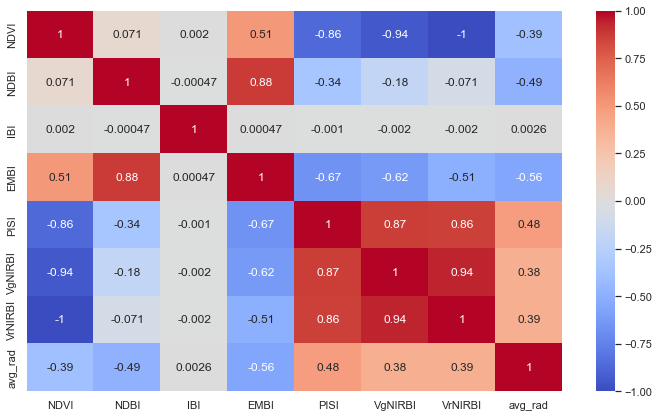

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(rc = {'figure.figsize':(12,7)})
sns.heatmap(X1.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [40]:
# import packages
import pandas as pd

# import data


from sklearn.feature_selection import SelectKBest, chi2,f_classif
X1=chicago_final[['NDVI','NDBI','IBI','EMBI','PISI','VgNIRBI','VrNIRBI','avg_rad']]
y1=chicago_final['label']
X = X1
y = y1
# import packages
import pandas as pd

# import data


from sklearn.feature_selection import RFECV 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

regressor = RandomForestClassifier()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X,y)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X.loc[:, feature_selector.get_support()]

plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_), 4)})")
plt.tight_layout() 
plt.show()

KeyboardInterrupt: 

In [38]:
X_new

,NDVI,PISI,VgNIRBI,VrNIRBI,EMBI,avg_rad,NDBI
0,0.056495,0.123847,-0.125692,-0.056495,-0.554015,146.229996,-0.503052
1,0.050158,0.137228,-0.069421,-0.050158,-0.672663,130.559998,-0.630724
2,0.037951,0.143952,-0.079469,-0.037951,-0.672128,150.059998,-0.633029
3,0.101323,0.084140,-0.136176,-0.101323,-0.586225,183.259995,-0.544448
4,0.034653,0.144826,-0.050686,-0.034653,-0.573448,167.559998,-0.508737
...,...,...,...,...,...,...,...
82635,0.091685,0.116853,-0.073071,-0.091685,-0.373019,179.089996,-0.285815
82636,0.286335,0.018011,-0.315820,-0.286335,-0.088514,63.419998,-0.103626
82637,0.047111,0.115779,-0.072716,-0.047111,-0.258852,82.180000,-0.132842
82638,0.153113,0.055556,-0.217288,-0.153113,-0.051132,77.290001,0.013672


In [75]:
#Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score,accuracy_score,roc_curve,plot_roc_curve 
# Define our dependent and independent variables
X1=chicago_final[['avg_rad']]
y1=chicago_final['label']
#X2=turbo_volos_filled[['NDVI','NDBI','UI','IBI']]
#y2=turbo_volos_filled['label']

#X=X1.append(X2,ignore_index=True)
#y=y1.append(y2,ignore_index=True)

X_train,x_test,Y_train,y_test = train_test_split(X1,y1, test_size=0.3, random_state=1)

start_time = time.monotonic()
classifier = RandomForestClassifier(random_state = 1, max_depth = 20, n_estimators = 600, min_samples_split = 2, min_samples_leaf = 1)

classifier.fit(X_train, Y_train)
end_time = time.monotonic()
y_pred = classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))

print(timedelta(seconds=end_time - start_time))



0.6017263633430139
0:01:00.922000


In [74]:
import joblib
joblib.dump(classifier, 'rf_vgnirbi_avg_rad.pkl')

['rf_vgnirbi_avg_rad.pkl']

In [ ]:
#Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score,accuracy_score,roc_curve,plot_roc_curve 
# Define our dependent and independent variables
X1=chicago_final[['NDVI','NDBI','IBI','EMBI','PISI','VgNIRBI','VrNIRBI','avg_rad']]
y1=chicago_final['label']
#X2=turbo_volos_filled[['NDVI','NDBI','UI','IBI']]
#y2=turbo_volos_filled['label']

#X=X1.append(X2,ignore_index=True)
#y=y1.append(y2,ignore_index=True)

X_train,x_test,Y_train,y_test = train_test_split(X1,y1, test_size=0.3, random_state=1)

start_time = time.monotonic()
classifier = RandomForestClassifier(random_state = 1, max_depth = 30, n_estimators = 450, min_samples_split = 2, min_samples_leaf = 1)

classifier.fit(X_train, Y_train)
end_time = time.monotonic()
y_pred = classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))

print(timedelta(seconds=end_time - start_time))



In [22]:
# Feature Importance


from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(classifier.get_params())
# # Get numerical feature importances
# importances = list(classifier.feature_importances_)

# # List of tuples with variable and importance
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# # Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [4]:
# Try Feature Scaling.  Returns worse results. And since negatives are important in our case,  this is not a viable approach.



X_train,x_test,Y_train,y_test = train_test_split(X1,y1, test_size=0.3, random_state=1)
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
classifier = RandomForestClassifier(n_estimators=50)

classifier.fit(X_train, Y_train)
y_pred = classifier.predict(x_test)
accuracy_score(y_test, y_pred)



NameError: name 'train_test_split' is not defined